In [18]:
pip install ultralytics


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/974.5 kB ? eta -:--:--
   ---------------------------------------- 974.5/974.5 kB 9.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
import cv2
import os
import numpy as np
from pathlib import Path

# Your image dataset path
DATASET_PATH = r"C:\Users\sivab\Downloads\archive (15)\crop" # each subfolder is a class
YOLO_DATASET_PATH = "yolo_dataset"

classes = sorted(os.listdir(DATASET_PATH))  # 40 aircraft classes

for class_id, class_name in enumerate(classes):
    class_input_dir = os.path.join(DATASET_PATH, class_name)
    class_output_img_dir = os.path.join(YOLO_DATASET_PATH, "images", class_name)
    class_output_label_dir = os.path.join(YOLO_DATASET_PATH, "labels", class_name)
    os.makedirs(class_output_img_dir, exist_ok=True)
    os.makedirs(class_output_label_dir, exist_ok=True)

    for img_file in os.listdir(class_input_dir):
        if not img_file.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        img_path = os.path.join(class_input_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        _, thresh = cv2.threshold(blur, 60, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue

        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Normalize for YOLO
        H, W = img.shape[:2]
        x_center = (x + w / 2) / W
        y_center = (y + h / 2) / H
        w_norm = w / W
        h_norm = h / H

        # Save image and label
        cv2.imwrite(os.path.join(class_output_img_dir, img_file), img)
        label_path = os.path.join(class_output_label_dir, img_file.replace(".jpg", ".txt").replace(".png", ".txt"))
        with open(label_path, "w") as f:
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")


In [24]:
import os
import shutil
import random
from glob import glob
from tqdm import tqdm

# Paths
original_images_path = 'yolo_dataset/images'
original_labels_path = 'yolo_dataset/labels'

# Output paths
output_base = 'yolo_dataset'
image_train_out = os.path.join(output_base, 'images/train')
image_val_out = os.path.join(output_base, 'images/val')
label_train_out = os.path.join(output_base, 'labels/train')
label_val_out = os.path.join(output_base, 'labels/val')

# Make dirs
for p in [image_train_out, image_val_out, label_train_out, label_val_out]:
    os.makedirs(p, exist_ok=True)

# Collect all image files (assuming .jpg or .png)
image_extensions = ('*.jpg', '*.jpeg', '*.png')
image_files = []
for ext in image_extensions:
    image_files.extend(glob(os.path.join(original_images_path, '*', ext)))

# Shuffle and split
random.shuffle(image_files)
split_index = int(0.8 * len(image_files))
train_files = image_files[:split_index]
val_files = image_files[split_index:]

# Move files
def move_data(files, image_dest, label_dest):
    for img_path in tqdm(files, desc=f"Moving to {image_dest}"):
        filename = os.path.basename(img_path)
        class_name = os.path.basename(os.path.dirname(img_path))
        label_path = os.path.join(original_labels_path, class_name, os.path.splitext(filename)[0] + '.txt')
        
        if not os.path.exists(label_path):
            continue  # skip images without labels
        
        shutil.copy(img_path, os.path.join(image_dest, filename))
        shutil.copy(label_path, os.path.join(label_dest, os.path.splitext(filename)[0] + '.txt'))

# Do the move
move_data(train_files, image_train_out, label_train_out)
move_data(val_files, image_val_out, label_val_out)


Moving to yolo_dataset\images/val: 100%|██████████| 4109/4109 [01:10<00:00, 57.89it/s]


In [1]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # or yolov8s.pt for slightly better accuracy
model.train(data="yolo_dataset/data.yaml", epochs=30, imgsz=640)


Ultralytics 8.3.107  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=yolo_dataset/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

train: Scanning C:\Users\sivab\.cache\kagglehub\datasets\a2015003713\militaryaircraftdetectiondataset\versions\86\yolo_dataset\labels\train.cache... 16405 images, 0 backgrounds, 27 corrupt: 100%|██████████| 16432/16432 [00:00<?, ?it/s]

train: WARNING  C:\Users\sivab\.cache\kagglehub\datasets\a2015003713\militaryaircraftdetectiondataset\versions\86\yolo_dataset\images\train\0c1f9a40df584f13cf3b71dcb0968ec2_10.jpg: ignoring corrupt image/label: image size (9, 62) <10 pixels
train: WARNING  C:\Users\sivab\.cache\kagglehub\datasets\a2015003713\militaryaircraftdetectiondataset\versions\86\yolo_dataset\images\train\17db760b818b49bbd125dbac4c5fdeef_1.jpg: ignoring corrupt image/label: image size (9, 19) <10 pixels
train: WARNING  C:\Users\sivab\.cache\kagglehub\datasets\a2015003713\militaryaircraftdetectiondataset\versions\86\yolo_dataset\images\train\20119511433f4033037247136d240dbf_1.jpg: ignoring corrupt image/label: image size (9, 54) <10 pixels
train: WARNING  C:\Users\sivab\.cache\kagglehub\datasets\a2015003713\militaryaircraftdetectiondataset\versions\86\yolo_dataset\images\train\24ccde194acc7ed186a529293d7cbbff_0.jpg: ignoring corrupt image/label: image size (8, 44) <10 pixels
train: WARNING  C:\Users\sivab\.cache\k


val: Scanning C:\Users\sivab\.cache\kagglehub\datasets\a2015003713\militaryaircraftdetectiondataset\versions\86\yolo_dataset\labels\val.cache... 4102 images, 0 backgrounds, 7 corrupt: 100%|██████████| 4109/4109 [00:00<?, ?it/s]

val: WARNING  C:\Users\sivab\.cache\kagglehub\datasets\a2015003713\militaryaircraftdetectiondataset\versions\86\yolo_dataset\images\val\43b4d0f2e3bda68f420c5ae8d9861c95_0.jpg: ignoring corrupt image/label: image size (8, 29) <10 pixels
val: WARNING  C:\Users\sivab\.cache\kagglehub\datasets\a2015003713\militaryaircraftdetectiondataset\versions\86\yolo_dataset\images\val\a07b28717e967e3aef1d9971871ae5e5_2.jpg: ignoring corrupt image/label: image size (9, 38) <10 pixels
val: WARNING  C:\Users\sivab\.cache\kagglehub\datasets\a2015003713\militaryaircraftdetectiondataset\versions\86\yolo_dataset\images\val\a3bd4cb0c7082a156f093cfdbe319792_4.jpg: ignoring corrupt image/label: image size (5, 10) <10 pixels
val: WARNING  C:\Users\sivab\.cache\kagglehub\datasets\a2015003713\militaryaircraftdetectiondataset\versions\86\yolo_dataset\images\val\d541ae8e2d1baa85cca673fe708c4a6b_1.jpg: ignoring corrupt image/label: image size (9, 23) <10 pixels
val: WARNING  C:\Users\sivab\.cache\kagglehub\datasets\a

Plotting labels to runs\detect\train6\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000227, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train6
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.11G     0.6672      3.854      1.254         14        640: 100%|██████████| 1026/1026 [03:57<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:30<00:00,  4.19it/s]


                   all       4102       4102      0.421      0.115     0.0564      0.043

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.19G     0.5931      3.036      1.186         19        640: 100%|██████████| 1026/1026 [03:41<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:28<00:00,  4.51it/s]


                   all       4102       4102      0.366      0.232      0.112     0.0832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.19G     0.5664      2.635      1.154         19        640: 100%|██████████| 1026/1026 [03:32<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:26<00:00,  4.85it/s]


                   all       4102       4102      0.335       0.28      0.167      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.19G     0.5551      2.429      1.144         14        640: 100%|██████████| 1026/1026 [03:30<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:25<00:00,  5.09it/s]


                   all       4102       4102      0.498      0.286      0.233      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.19G     0.5411      2.274      1.135         13        640: 100%|██████████| 1026/1026 [03:31<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:25<00:00,  5.07it/s]


                   all       4102       4102      0.443      0.321      0.268      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.19G     0.5288      2.158      1.126         13        640: 100%|██████████| 1026/1026 [03:32<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:26<00:00,  4.81it/s]


                   all       4102       4102      0.546      0.348      0.325       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.19G     0.5204      2.055      1.121         17        640: 100%|██████████| 1026/1026 [03:30<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:25<00:00,  5.06it/s]


                   all       4102       4102      0.558      0.382      0.369      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.19G     0.5176      1.982      1.118         19        640: 100%|██████████| 1026/1026 [03:29<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:25<00:00,  5.02it/s]


                   all       4102       4102      0.534      0.398      0.397      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.19G     0.5063      1.899      1.112         17        640: 100%|██████████| 1026/1026 [03:29<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:24<00:00,  5.17it/s]


                   all       4102       4102      0.496       0.43      0.425      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.19G     0.4977      1.836      1.103         14        640: 100%|██████████| 1026/1026 [03:30<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:25<00:00,  5.10it/s]


                   all       4102       4102       0.55      0.441      0.455      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.19G     0.4962      1.791      1.103         10        640: 100%|██████████| 1026/1026 [03:29<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:25<00:00,  5.09it/s]

                   all       4102       4102      0.558      0.441      0.473      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.19G     0.4861      1.728      1.098         12        640: 100%|██████████| 1026/1026 [03:29<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:25<00:00,  5.12it/s]


                   all       4102       4102      0.611       0.47      0.506      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.19G     0.4822      1.676      1.094         15        640: 100%|██████████| 1026/1026 [03:28<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:24<00:00,  5.20it/s]

                   all       4102       4102       0.53      0.514      0.519      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.19G     0.4761      1.632       1.09         18        640: 100%|██████████| 1026/1026 [03:33<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:33<00:00,  3.81it/s]


                   all       4102       4102       0.62        0.5      0.546      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.19G     0.4714      1.602      1.086         15        640: 100%|██████████| 1026/1026 [04:34<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:32<00:00,  4.01it/s]


                   all       4102       4102      0.673      0.488      0.559      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.19G     0.4702      1.568      1.087         12        640: 100%|██████████| 1026/1026 [04:36<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:33<00:00,  3.86it/s]


                   all       4102       4102      0.621      0.527      0.575      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.19G     0.4632      1.534      1.082         15        640: 100%|██████████| 1026/1026 [04:36<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:33<00:00,  3.81it/s]


                   all       4102       4102      0.628      0.524      0.578      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.19G     0.4567      1.488      1.076         13        640: 100%|██████████| 1026/1026 [04:36<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:33<00:00,  3.81it/s]


                   all       4102       4102      0.651      0.532      0.592      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.19G     0.4524      1.463      1.075         15        640: 100%|██████████| 1026/1026 [04:35<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:33<00:00,  3.85it/s]


                   all       4102       4102      0.706      0.532      0.615      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.19G     0.4475      1.435      1.069         15        640: 100%|██████████| 1026/1026 [04:33<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:33<00:00,  3.82it/s]


                   all       4102       4102       0.69      0.567      0.617      0.514
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.19G     0.4255      1.135      1.102          5        640: 100%|██████████| 1026/1026 [04:37<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:39<00:00,  3.29it/s]


                   all       4102       4102      0.638      0.589      0.633      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.19G     0.4067      1.044      1.081          5        640: 100%|██████████| 1026/1026 [04:33<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:33<00:00,  3.82it/s]


                   all       4102       4102      0.753       0.55      0.651      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.19G      0.396     0.9775      1.075          5        640: 100%|██████████| 1026/1026 [05:57<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:32<00:00,  3.92it/s]


                   all       4102       4102      0.708      0.592      0.651      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.19G     0.3856     0.9473      1.066          5        640: 100%|██████████| 1026/1026 [06:12<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:25<00:00,  5.11it/s]

                   all       4102       4102      0.729      0.582       0.66      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.19G     0.3785     0.9032      1.063          5        640: 100%|██████████| 1026/1026 [03:27<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:25<00:00,  5.15it/s]

                   all       4102       4102      0.711      0.605      0.663      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.19G     0.3719     0.8632      1.056          5        640: 100%|██████████| 1026/1026 [03:30<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:25<00:00,  5.16it/s]

                   all       4102       4102      0.716      0.588       0.67      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.19G     0.3656     0.8307      1.046          5        640: 100%|██████████| 1026/1026 [03:27<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:25<00:00,  5.05it/s]

                   all       4102       4102      0.718      0.609      0.684      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.19G     0.3572     0.7973      1.043          5        640: 100%|██████████| 1026/1026 [03:27<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:24<00:00,  5.18it/s]

                   all       4102       4102      0.799      0.572      0.681      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.19G     0.3528     0.7721      1.036          5        640: 100%|██████████| 1026/1026 [03:28<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:25<00:00,  5.15it/s]

                   all       4102       4102      0.742      0.596      0.682      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.19G     0.3436     0.7531      1.032          5        640: 100%|██████████| 1026/1026 [03:27<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:25<00:00,  5.10it/s]

                   all       4102       4102      0.739      0.604      0.684      0.585



30 epochs completed in 2.252 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 6.2MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics 8.3.107  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,013,448 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [00:26<00:00,  4.88it/s]


                   all       4102       4102      0.747      0.598      0.683      0.585
                   A10        144        144      0.825      0.751      0.837      0.723
                 A400M        106        106      0.791      0.642      0.785       0.67
                  An22         23         23      0.471      0.565      0.497      0.408
                 An225         26         26       0.51      0.192      0.328      0.305
                  An72         41         41      0.815      0.536       0.71      0.571
                    B1        101        101      0.892      0.762      0.834      0.756
                    B2         99         99      0.774      0.798      0.867       0.79
                   B21          7          7          1          0     0.0397     0.0285
                   B52        127        127      0.728      0.717      0.811      0.686
                  C130        319        319       0.74      0.722      0.802      0.705
                   C1

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002B58FD88A60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,   

In [3]:
print(df.columns.tolist())


['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


📉 Plotting Losses...


C:\Users\sivab\AppData\Local\Temp\ipykernel_14348\2262971075.py:38: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\sivab\anaconda3\envs\pytorch-gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


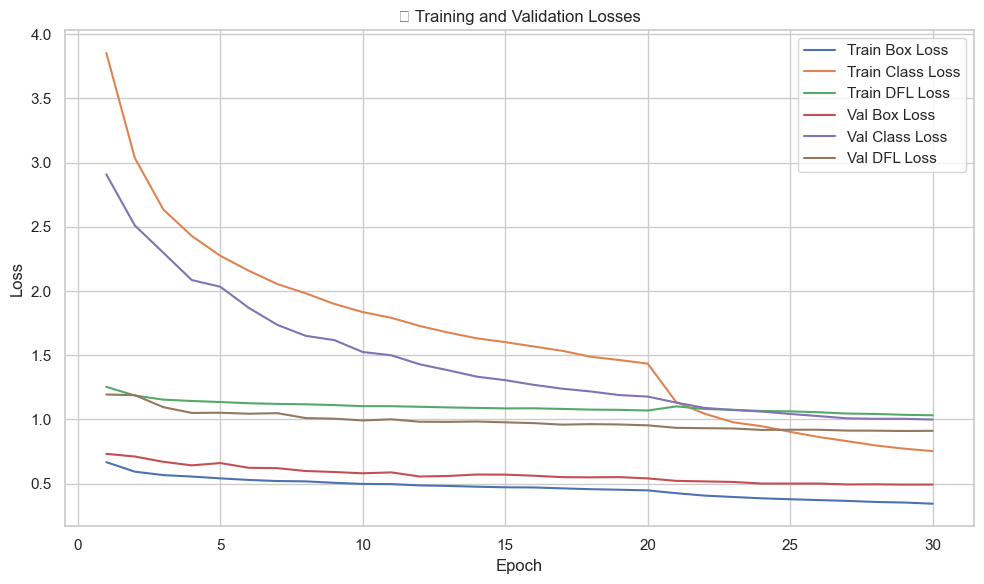

🎯 Plotting Precision & Recall...


C:\Users\sivab\AppData\Local\Temp\ipykernel_14348\2262971075.py:52: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\sivab\anaconda3\envs\pytorch-gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


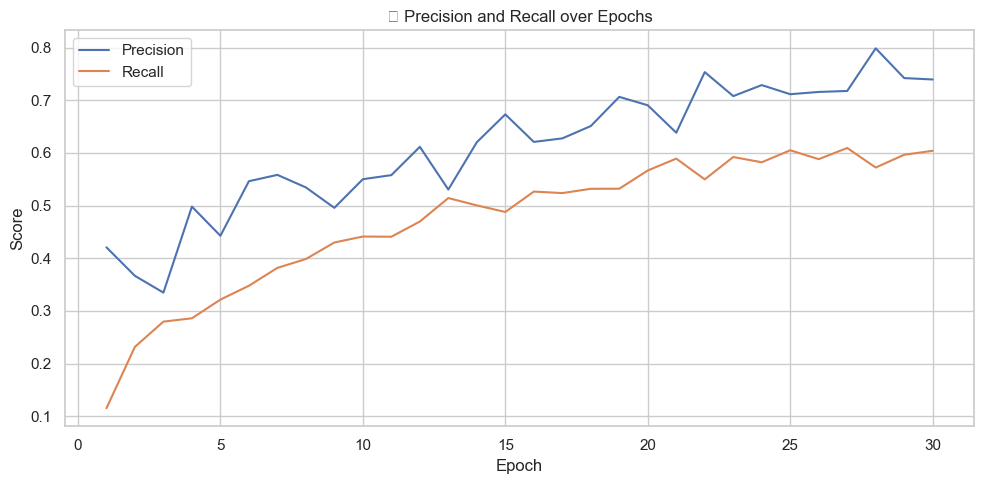

🏆 Plotting mAP Scores...


C:\Users\sivab\AppData\Local\Temp\ipykernel_14348\2262971075.py:66: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\sivab\anaconda3\envs\pytorch-gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


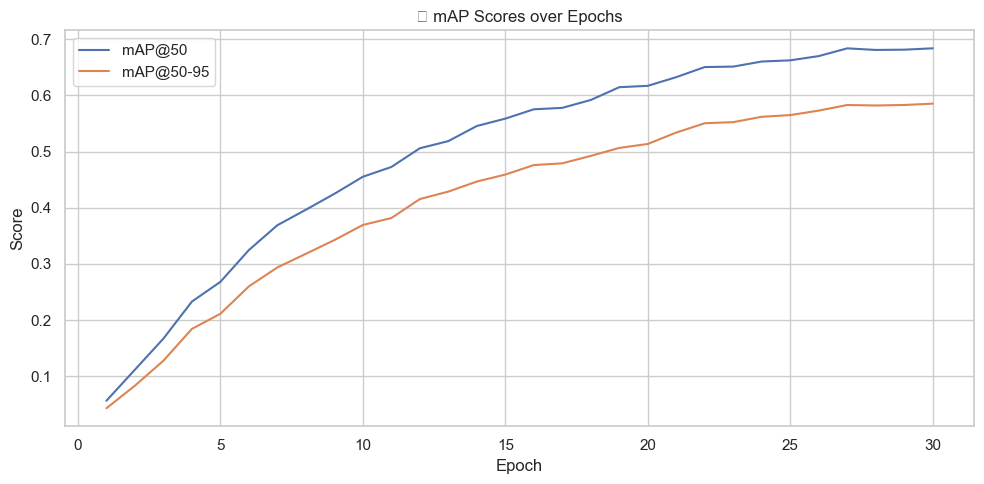

In [9]:
# Add this if you're using Jupyter
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import os

# ✅ Update this to match your run folder
csv_path = "runs/detect/train6/results.csv"

# ✅ Load the CSV safely
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"File not found: {csv_path}")
df = pd.read_csv(csv_path)

# ✅ Helper function to plot if column exists
def safe_plot(x_col, y_col, label=None):
    if y_col in df.columns:
        plt.plot(df[x_col], df[y_col], label=label if label else y_col)
    else:
        print(f"⚠️ Column not found: {y_col}")

# 📉 Plot losses
def plot_losses():
    print("📉 Plotting Losses...")
    plt.figure(figsize=(10, 6))
    safe_plot('epoch', 'train/box_loss', 'Train Box Loss')
    safe_plot('epoch', 'train/cls_loss', 'Train Class Loss')
    safe_plot('epoch', 'train/dfl_loss', 'Train DFL Loss')
    safe_plot('epoch', 'val/box_loss', 'Val Box Loss')
    safe_plot('epoch', 'val/cls_loss', 'Val Class Loss')
    safe_plot('epoch', 'val/dfl_loss', 'Val DFL Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("📉 Training and Validation Losses")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 🎯 Plot Precision & Recall
def plot_precision_recall():
    print("🎯 Plotting Precision & Recall...")
    plt.figure(figsize=(10, 5))
    safe_plot('epoch', 'metrics/precision(B)', 'Precision')
    safe_plot('epoch', 'metrics/recall(B)', 'Recall')
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("🎯 Precision and Recall over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 🏆 Plot mAP scores
def plot_map_scores():
    print("🏆 Plotting mAP Scores...")
    plt.figure(figsize=(10, 5))
    safe_plot('epoch', 'metrics/mAP50(B)', 'mAP@50')
    safe_plot('epoch', 'metrics/mAP50-95(B)', 'mAP@50-95')
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("🏆 mAP Scores over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ✅ Run all plots
plot_losses()
plot_precision_recall()
plot_map_scores()


In [10]:
import shutil

# Save to a specific path
shutil.copy("runs/detect/train6/weights/best.pt", "yolo_model_best.pt")


'yolo_model_best.pt'